In [12]:
using Pkg
Pkg.activate("..")
using Revise
using PythonPlot,Statistics,Distributions,DataFrames,CSV,Random
PythonPlot.svg(true)
using SizeStructuredPopulations
using SpecialFunctions
include("./examples.jl")

methods(generate_cell)

# seed the random number generator for reproducibility
Random.seed!(123);

  Activating project at `~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations`


In [13]:

model = GrowthModel(M1()...)
init = vcat([0.0], [0.0, 0.0], zeros(3))
T = 1000.0
dt = 0.01
Tmax = T

function terminate(cell)
    return cell.time[end] > Tmax 
end


dfs = []
for i in 1:100
    cell = simulate_lineage(model, T, init, dt = 0.01);
    df = lineage_to_dataframe(cell);
    df.lineage = fill(i, nrow(df))
    push!(dfs,df)
end
df = vcat(dfs...);


In [14]:
λ = M1()[1]
df.λ .= λ_vals = [λ(collect(row)) for row in eachrow(df[:,[:x1,:x2,:x3]])];
dt = df.time[2] - df.time[1]
dfR = combine(groupby(df,:lineage),:λ => cumsum => :R,:x1 => :x1,:time => :time)
dfR.R = dfR.R *dt# condtains for each lineage T and x as a function of time

dfR.num = exp.(dfR.R).*dfR.x1
dfR.dum = exp.(dfR.R)
dfR_avg = combine(groupby(dfR,:time),:num => mean => :num, :dum => mean => :dum)
# drop cols with NANA
dfR_avg = dropmissing(dfR_avg)

Row,time,num,dum
,Float64,Float64,Float64
1,0.0,0.0,1.01005
2,0.01,0.000605994,1.02021
3,0.02,0.00179177,1.03048
4,0.03,0.00336182,1.04087
5,0.04,0.0037737,1.05137
6,0.05,0.00471296,1.06198
7,0.06,0.00621761,1.07272
8,0.07,0.00804936,1.08358
9,0.08,0.0064616,1.09453


In [15]:
dfR_avg = dfR_avg[dfR_avg.time .< 500,:]

Row,time,num,dum
,Float64,Float64,Float64
1,0.0,0.0,1.01005
2,0.01,0.000605994,1.02021
3,0.02,0.00179177,1.03048
4,0.03,0.00336182,1.04087
5,0.04,0.0037737,1.05137
6,0.05,0.00471296,1.06198
7,0.06,0.00621761,1.07272
8,0.07,0.00804936,1.08358
9,0.08,0.0064616,1.09453


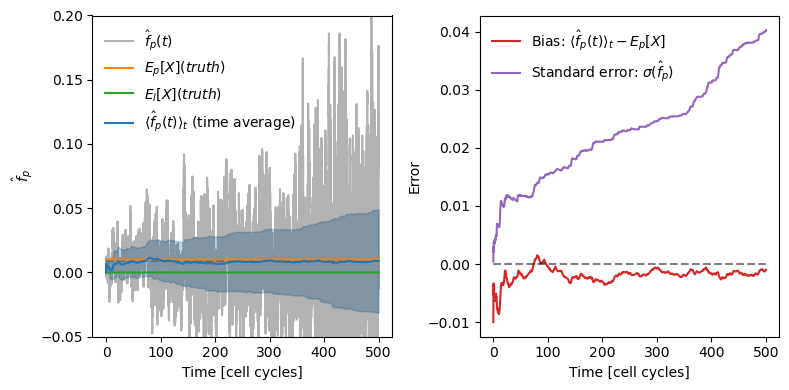

In [21]:
fig,axs = subplots(figsize=(8,4),ncols=2)

ax = axs[0]
u = dfR_avg.num ./ dfR_avg.dum
u_true = 0.01/1
ax.plot(dfR_avg.time,u,"k-",alpha=0.3,label=L"$\hat{f}_p(t)$")
ax.plot(dfR_avg.time,ones(length(u)).*mean(skipmissing(replace(u, NaN => missing))),"C0--")
ax.plot(dfR_avg.time,ones(length(u))*u_true,"C1-",label=L"$E_p[X] (truth)$")
ax.plot(dfR_avg.time,ones(length(u))*0.00/1,"C2-",label=L"$E_l[X] (truth)$")

# average u over moving window
window = 5000
#u_avg = [mean(u[max(1,i-window+1):i]) for i in 1:length(u)]
u_avg = [mean(u[1:i]) for i in 1:length(u)]#
u_err = [std(u[1:i]) for i in 1:length(u)]#
ax.plot(dfR_avg.time,u_avg,"C0-",label=L"$\langle \hat{f}_p(t) \rangle_t$ (time average)")
ax.fill_between(dfR_avg.time, u_avg .- u_err, u_avg .+ u_err, alpha=0.3, color="C0")
#ax.set_xlim(1,300)
ax.set_ylim([-0.05,0.2])
ax.set_xlabel("Time [cell cycles]")
ax.set_ylabel(L"$\hat{f}_p$")
ax.legend(frameon=false, loc="upper left")

ax = axs[1]
# Plot error between u_avg and truth
error_vs_truth = u_avg .- u_true
ax.plot(dfR_avg.time, error_vs_truth, "C3-", label=L"Bias: $\langle \hat{f}_p(t) \rangle_t - E_p[X]$")
ax.plot(dfR_avg.time, u_err, "C4-", label=L"Standard error: $\sigma(\hat{f}_p)$")
ax.plot(dfR_avg.time, zeros(length(dfR_avg.time)), "k--", alpha=0.5)
#ax.set_xlim(1,300)
ax.set_xlabel("Time [cell cycles]")
ax.set_ylabel("Error")
ax.legend(frameon=false)
tight_layout()
savefig("./Fig4.pdf")

fig